# Gradient Vanishing Analysis in VGG19
This notebook tracks and compares **average gradient norms per epoch** across multiple layers in VGG19 to observe potential vanishing gradients.

### Layers tracked:
- `features[0]`: Early convolutional layer
- `features[10]`: Mid-level convolutional layer
- `features[28]`: Deep convolutional layer
- `classifier[0]`: First fully connected layer

*Generated on: 2025-05-11*

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load pretrained VGG19 and modify classifier
vgg19 = models.vgg19(pretrained=True)
vgg19.classifier[6] = nn.Linear(4096, 10)

for module in vgg19.modules():
    if isinstance(module, nn.ReLU):
        module.inplace = False
        
vgg19 = vgg19.to(device)

/workspace/projects/dl-lab-notebooks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/projects/dl-lab-notebooks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
trainable_params = sum(p.numel() for p in vgg19.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 139,611,210


In [4]:
# Gradient storage
epoch_gradients = {
    'conv1': [], 'conv_mid': [], 'conv_deep': [], 'fc1': []
}
batch_grads = {'conv1': [], 'conv_mid': [], 'conv_deep': [], 'fc1': []}

# Hook function
def register_hook(module, name):
    def hook(module, grad_input, grad_output):
        if grad_output[0] is not None:
            batch_grads[name].append(grad_output[0].norm().item())
    module.register_full_backward_hook(hook)

# Register hooks
register_hook(vgg19.features[0], 'conv1')
register_hook(vgg19.features[10], 'conv_mid')
register_hook(vgg19.features[28], 'conv_deep')
register_hook(vgg19.classifier[0], 'fc1')

In [5]:
# CIFAR-10 loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = datasets.CIFAR10(root='../data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg19.parameters(), lr=1e-4)

In [7]:
# Train for 10 epochs and log average gradient norms
for epoch in tqdm(range(10)):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg19(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Store average gradient per layer for this epoch
    for layer in batch_grads:
        avg_grad = np.mean(batch_grads[layer]) if batch_grads[layer] else 0
        epoch_gradients[layer].append(avg_grad)
        batch_grads[layer].clear()
    print(f"Epoch {epoch+1} complete")

 10%|█         | 1/10 [03:34<32:14, 214.98s/it]

Epoch 1 complete


 20%|██        | 2/10 [07:08<28:31, 213.91s/it]

Epoch 2 complete


 30%|███       | 3/10 [10:41<24:54, 213.53s/it]

Epoch 3 complete


 40%|████      | 4/10 [14:15<21:22, 213.69s/it]

Epoch 4 complete


 50%|█████     | 5/10 [17:48<17:48, 213.64s/it]

Epoch 5 complete


 60%|██████    | 6/10 [21:22<14:14, 213.71s/it]

Epoch 6 complete


 70%|███████   | 7/10 [24:57<10:42, 214.15s/it]

Epoch 7 complete


 80%|████████  | 8/10 [28:31<07:08, 214.04s/it]

Epoch 8 complete


 90%|█████████ | 9/10 [32:04<03:33, 213.86s/it]

Epoch 9 complete


100%|██████████| 10/10 [35:38<00:00, 213.83s/it]

Epoch 10 complete


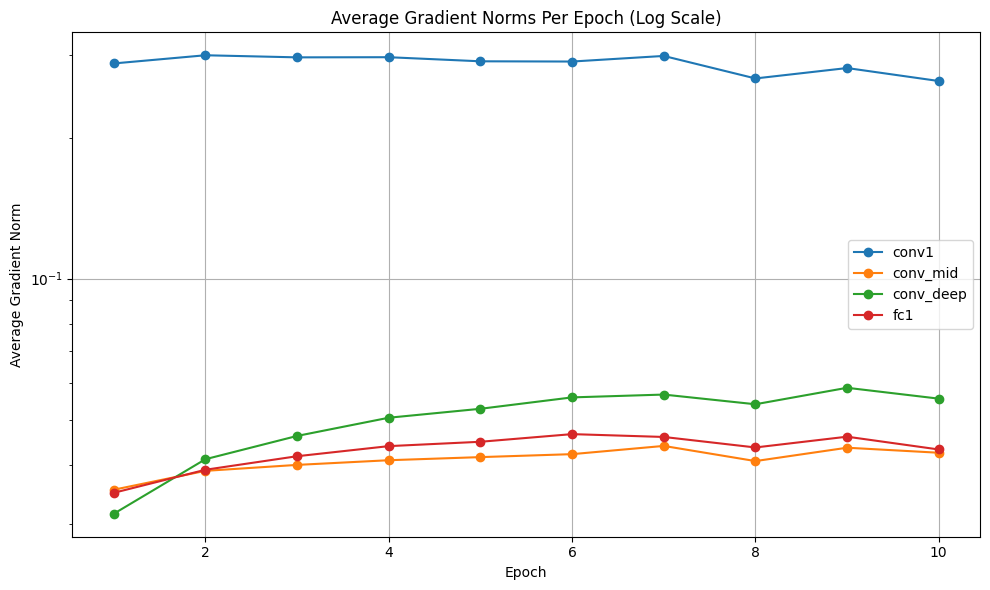

In [8]:
# Plot average gradient norms per epoch for each layer
plt.figure(figsize=(10, 6))
for layer, grads in epoch_gradients.items():
    plt.plot(range(1, len(grads)+1), grads, label=layer, marker='o')
plt.title("Average Gradient Norms Per Epoch (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("Average Gradient Norm")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()